In [1]:
import pandas as pd
import numpy as np
import random
import math
import operator
from math import sqrt
from random import shuffle
from decimal import Decimal
from sklearn.datasets import fetch_lfw_people
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy import cov
from numpy.linalg import eig
import heapq

In [2]:
people = fetch_lfw_people(min_faces_per_person = 20, resize = 0.7)
image_shape = people.images[0].shape

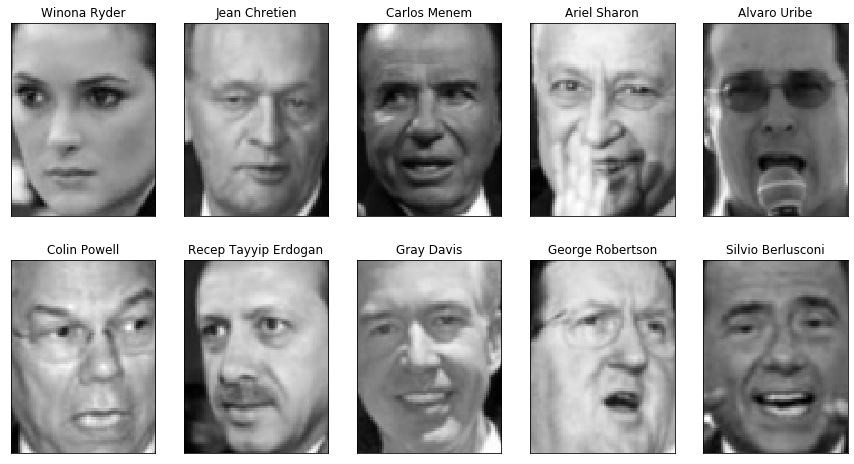

In [3]:
fig, axes = plt.subplots(2, 5, figsize = (15, 8), subplot_kw = {'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])

In [4]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [5]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name,count), end= '')
    if (i + 1)%3 == 0:
        print()

Alejandro Toledo           39Alvaro Uribe               35Amelie Mauresmo            21
Andre Agassi               36Angelina Jolie             20Ariel Sharon               77
Arnold Schwarzenegger      42Atal Bihari Vajpayee       24Bill Clinton               29
Carlos Menem               21Colin Powell              236David Beckham              31
Donald Rumsfeld           121George Robertson           22George W Bush             530
Gerhard Schroeder         109Gloria Macapagal Arroyo    44Gray Davis                 26
Guillermo Coria            30Hamid Karzai               22Hans Blix                  39
Hugo Chavez                71Igor Ivanov                20Jack Straw                 28
Jacques Chirac             52Jean Chretien              55Jennifer Aniston           21
Jennifer Capriati          42Jennifer Lopez             21Jeremy Greenstock          24
Jiang Zemin                20John Ashcroft              53John Negroponte            31
Jose Maria Aznar           23Jua

In [6]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target==target)[0][:50]]=1

X_people = people.data[mask]
y_people = people.target[mask]

X_people = X_people/255

In [7]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
print(X_train)
print(y_train.shape)

y_train = np.reshape(y_train, (y_train.shape[0], 1))
X_train_y= np.append(X_train, y_train, axis=1 )
y_test= np.reshape(y_test, (y_test.shape[0], 1))
X_test_y= np.append(X_test, y_test, axis=1 )
print(X_train_y.shape)
print(X_test_y.shape)

[[0.53594774 0.55947715 0.5647059  ... 0.5294118  0.40392157 0.24313726]
 [0.08888888 0.08627451 0.08888888 ... 0.38039216 0.43529412 0.4614379 ]
 [0.55424833 0.5464052  0.5411765  ... 0.84575164 0.8352941  0.793464  ]
 ...
 [0.4627451  0.4379085  0.40261436 ... 0.36732024 0.3647059  0.35816994]
 [0.14117648 0.20130718 0.18431373 ... 0.5673203  0.75032675 0.88366014]
 [0.04313726 0.02614379 0.01830065 ... 0.56601304 0.5869281  0.59607846]]
(1547,)
(1547, 5656)
(516, 5656)


In [125]:
##Trial K means

class K_Means_Clustering:
    def __init__(self, iter = 300):
        #self.k = k
        self.iter = iter
        
    def fit(self, k, X_data):
        
        self.centers = {}
        
        for i in range(k):
            self.centers[i] = X_data[i]
        
        for i in range(self.iter):
            self.clusters = {}
            #print(self.clusters)
            for i in range(k):
                self.clusters[i] = []
                
            for row in X_data:
                dist = [np.linalg.norm(row-self.centers[centers]) for centers in self.centers]
                cluster = dist.index(min(dist))
                #classification = argmin(dist)
                self.clusters[cluster].append(row)
            
            prev_centers = dict(self.centers)
            #print(self.centers)
            for i in self.centers :
                if any(np.abs(self.centers[i] - prev_centers[i]))<2^-23:
                    break
            #print(self.centers)
            
            #if np.abs(self.centers - prev_centers)<2^-23:
              #  break
            
            for cluster in self.clusters:
                self.centers[cluster] = np.average(self.clusters[cluster],axis=0)
            

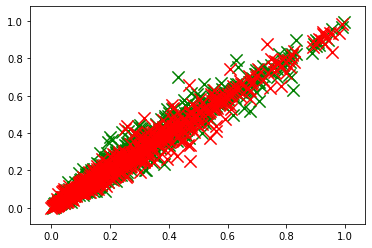

In [114]:
####Test K-Means for k=2
colors = 10*["g","r","c","b","k"]

K_test = K_Means_Clustering()
K_test.fit(2, X_train)

for center in K_test.centers:
    #print(center)
    plt.scatter(K_test.centers[center][0], K_test.centers[center][1], marker="o", color="k", s=150, linewidths=5)
    
for cluster in K_test.clusters:
    color = colors[cluster]
    for row in K_test.clusters[cluster]:
        plt.scatter(row[0], row[1], marker="x", color=color, s=150, linewidths=5)

In [17]:
X_mean = X_train.mean(axis=0)
#print(X_mean)
X_std = X_train.std(axis=0)
#print(X_std)
#print(X.T)
X_train_std = np.asarray([(X_train.T[i]-X_mean[i])/X_std[i] for i in range(X_train.T.shape[0])]).T
print(X_train_std.shape)

(1547, 5655)


In [18]:
X_cov = cov(X_train_std.T)
print(X_cov.shape)
eig_values, eig_vectors = eig(X_cov)

eig_values = np.real(eig_values)
eig_vectors = np.real(eig_vectors)
print(eig_values.shape)
print(eig_vectors.shape)

(5655, 5655)
(5655,)
(5655, 5655)


In [31]:
####PCA

normalized_eig_vectors = preprocessing.normalize(eig_vectors)
print(normalized_eig_vectors.shape)
D_eig_vector = normalized_eig_vectors[:,0:100]
print(D_eig_vector.shape)

np.random.seed(0)
np.random.shuffle(X_train_std)
#print(X_train_std)
#print(X_train_std.shape)

projected_D_train = X_train_std.dot(D_eig_vector)
print(projected_D_train.shape)

(5655, 5655)
(5655, 100)
(1547, 100)


212
189
197
44
158
121
149
124
161
192


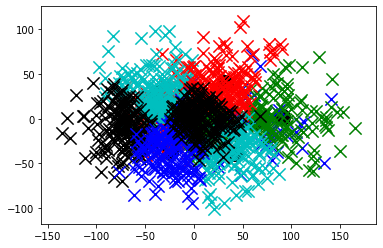

In [132]:
####K_Means on reduced data
colors = 10*["g","r","c","b","k"]

K_train_D = K_Means_Clustering()
K_train_D.fit(10, projected_D_train)

for center in K_train_D.centers:
    plt.scatter(K_train_D.centers[center][0], K_train_D.centers[center][1], marker="o", color="k", s=150, linewidths=5)


for cluster in K_train_D.clusters:
    neighbors = 0
    color = colors[cluster]
    #print(K_train_D.clusters[cluster].shape)
    for row in K_train_D.clusters[cluster]:
        neighbors += 1
        #print(row.shape)
        plt.scatter(row[0], row[1], marker="x", color=color, s=150, linewidths=5)
    print(neighbors)

In [120]:
### Reconstruct the cluster centers

recon_list = []

for i in K_train_D.centers:
    k = K_train_D.centers[i]
    print(k.shape)
    recon_list.append(k)
    

recon_centers = np.array(recon_list)
print(recon_centers.shape)

reconstruct = recon_centers.dot(D_eig_vector.T)
print(reconstruct.shape)

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(10, 100)
(10, 5655)


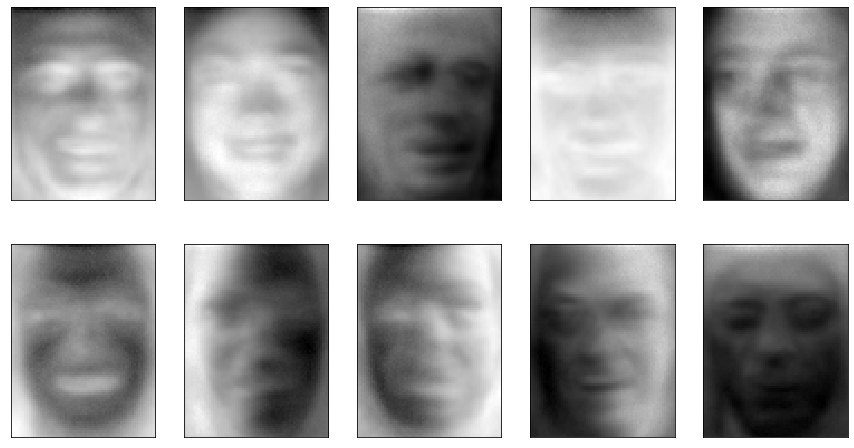

In [121]:
fig, axes = plt.subplots(2, 5, figsize = (15, 8), subplot_kw = {'xticks': (), 'yticks': ()})
for  image, ax in zip(reconstruct, axes.ravel()):
    #ax.figure()
    ax.imshow(image.reshape(87,65), cmap=cm.gray)
    #ax.set_title(people.target_names[target])

Closest:  794
Farthest:  582
Closest:  794
Farthest:  1398
Closest:  91
Farthest:  722
Closest:  724
Farthest:  925
Closest:  295
Farthest:  411
Closest:  1415
Farthest:  71
Closest:  1292
Farthest:  301
Closest:  275
Farthest:  730
Closest:  524
Farthest:  1506
Closest:  524
Farthest:  220


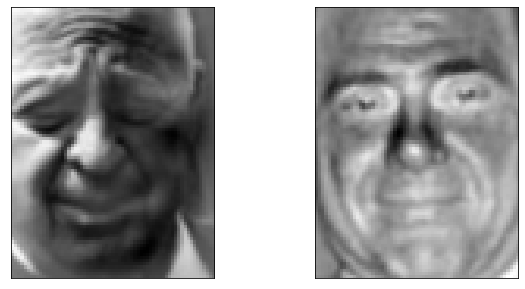

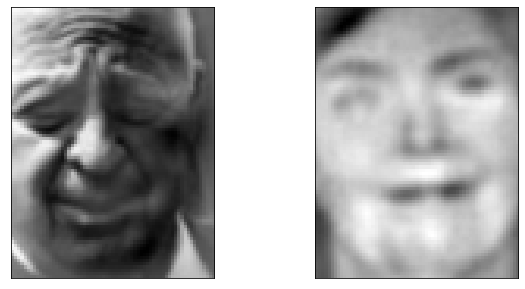

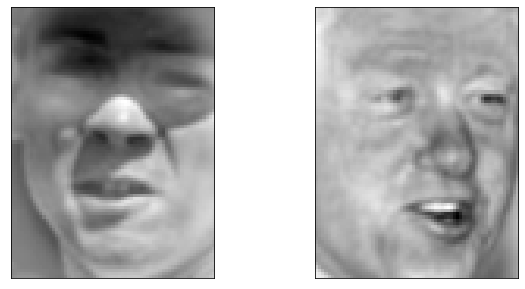

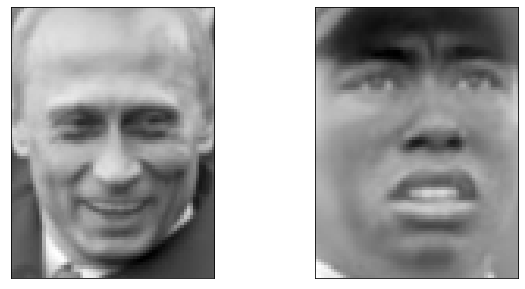

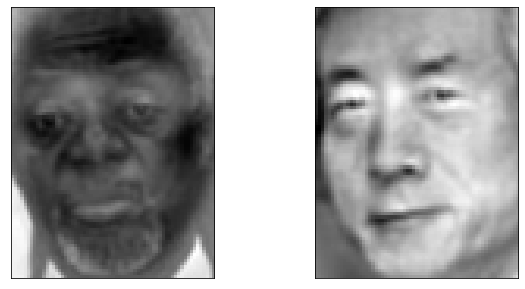

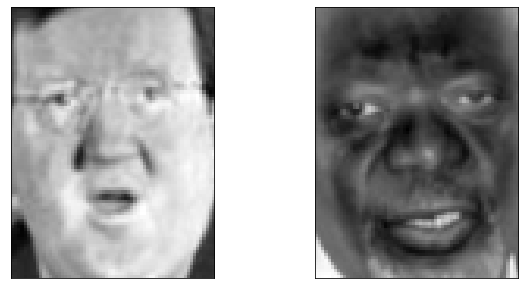

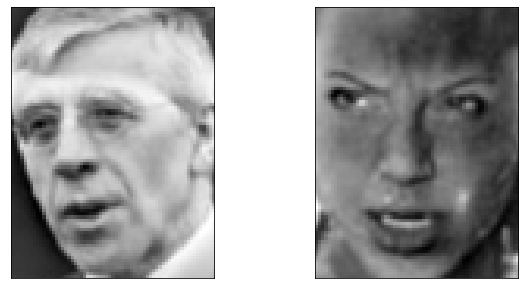

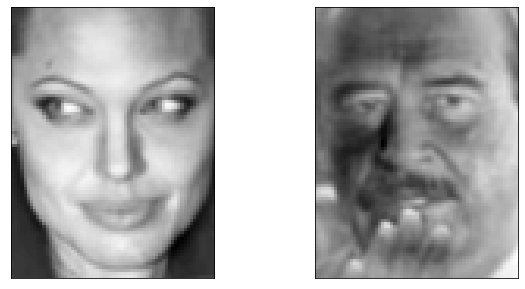

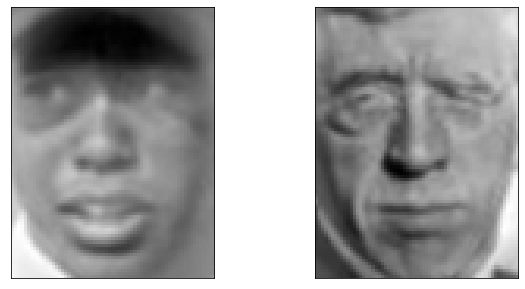

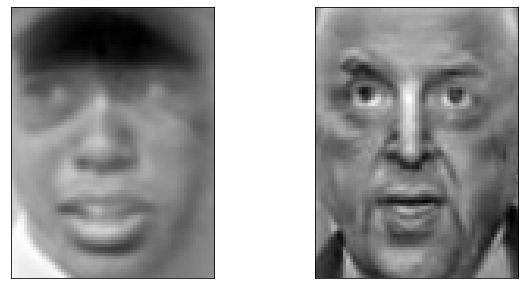

In [118]:
for center in range(reconstruct.shape[0]):
    D = {}
    for i in range(X_train_std.shape[0]):
        dist = np.linalg.norm(reconstruct[center] - X_train_std[i])
        D.update({i : dist})
    
    #print(D)
    temp = []
    temp_indices = []
    max_min_pair = []
    for i in D:
        k = D[i]
        temp.append(k)
        temp_indices.append(i)
    temp = np.array(temp)
    temp_indices = np.array(temp_indices)
    Max = np.argmax(temp)
    Min = np.argmin(temp)
    
    result_index_Max = temp_indices[Max]
    result_index_Min = temp_indices[Min]
    print("Closest: ", result_index_Max)
    print("Farthest: ", result_index_Min)
    max_min_pair.append(result_index_Max)
    max_min_pair.append(result_index_Min)
    max_min_pair = np.array(max_min_pair)
    
    fig, axes = plt.subplots(1, 2, figsize = (10, 5), subplot_kw = {'xticks': (), 'yticks': ()})
    for i, ax in zip(max_min_pair, axes.ravel()):
        ax.imshow(X_train_std[i].reshape(87,65), cmap=cm.gray)
        #ax.imshow(X_train_std[result_index_Min].reshape(87,65), cmap=cm.gray)
    del max_min_pair
    
#plt.imshow(X_train_std[result_index_Max].reshape(87,65), cmap=cm.gray)
    